# THIS IS THE BINARY VERSION

In [1]:
import sys, os, shutil, random, math, copy
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import sklearn
from datetime import datetime, timedelta
from sklearn.metrics import *
from sklearn.utils import class_weight
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

# Transformer model
from transformers import AutoModel

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Check ROCM (If the 6700 XT is detected and used)
print(tf.config.list_physical_devices('GPU'))

# Increase the Pandas's output cell size
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 700)
pd.set_option('display.width', 1000)

[]


In [3]:
# Load a csv file
filename = 'data/old/SlowALL1028.csv'
#filename = 'data/train/FalseALL0503.csv'
df = pd.read_csv(filename, skiprows=0)

# Get the timestamp
timestamp = df.iloc[0, 1]
print("Timestamp is:", timestamp)

# Skipping 2 rows
df = pd.read_csv(filename, skiprows=2)
df.head()

Timestamp is: 11084432530404


,X_ACC,Y_ACC,Z_ACC,X_GYRO,Y_GYRO,Z_GYRO,X_GRAVITY,Y_GRAVITY,Z_GRAVITY,X_MF,Y_MF,Z_MF,X_GMRV,Y_GMRV,Z_GMRV,TIME,LABEL
0,0.000000,0.000000,0.000000,-0.060718,-0.124100,-0.072569,-1.485139,-9.625180,1.149191,16.425001,30.900002,-23.625000,0.059273,0.661736,-0.745872,09:20,Slow
1,0.361434,-0.069506,-0.183116,-0.050332,0.279357,-0.184951,-0.813987,-9.740896,0.789142,15.975000,31.350000,-23.325000,0.061875,0.671938,-0.737999,-,Slow
2,-0.498501,0.106033,-0.042135,-0.166842,-0.027163,-0.154991,-0.761580,-9.767053,0.441673,15.825001,31.950000,-22.800001,0.060068,0.678037,-0.732405,-,Slow
3,-0.294392,0.135044,-0.124209,0.378557,0.000266,0.109186,-1.081274,-9.678743,1.150286,15.675000,32.250000,-22.500000,0.058626,0.675214,-0.734926,-,Slow
4,-0.121321,-2.650278,-1.438031,2.396508,-1.170425,1.418624,-2.670674,-7.778295,5.341912,15.600000,30.975000,-23.550001,0.042716,0.603473,-0.787595,09:21,Slow


In [4]:
def ConvertHourMinToHourMinSec(time_col):
    """Calculate timespan to seconds accuracy"""
    if len(str.split(time_col[0], ':')) == 2:
        # Get the initial time (h:m format)
        extended_time = time_col[0]

        # Calculating the steps until the next minute starts
        steps_to_next_min : int = 1
        r = time_col[1]
        while (r == '-'):
            steps_to_next_min += 1
            r = time_col[steps_to_next_min]

        # Adding the calculated seconds to the initial time (h:m:s)
        seconds = int(60 - np.round(steps_to_next_min / (300 / 60), 0))
        extended_time += f":{seconds}"
        return extended_time
    return time_col[0]

def ConvertOldDataToNewFormat(df, path : str, save_to_csv = False):
    # Defining the return dataframe
    df_to_return = df.copy(deep=True)
    # Get the first time with seconds accuracy and convert it to datetime format
    extended_time = ConvertHourMinToHourMinSec(df['TIME'])
    extended_time = datetime.strptime(extended_time, "%H:%M:%S") # Don't be fooled this variable contains the year, month, days too

    # The r_counter will take care of the sample gathering bc usually for every second we have 5 rows of data
    # Since we automatically increase the time with one sec, then we have to lower the initial value by 1
    r_counter = 1
    extended_time -= timedelta(seconds=1)

    # Inserting the new time formats
    for i, r in df_to_return.iterrows():
        if r_counter == 5 or r['TIME'] != '-':
            extended_time += timedelta(seconds=1)
            df_to_return.at[i, 'TIME'] = extended_time.strftime("%H:%M:%S")
            r_counter = 1
        else:
            df_to_return.at[i, 'TIME'] = extended_time.strftime("%H:%M:%S")
            r_counter += 1

    if (save_to_csv):
        df.to_csv(path, index=False)
    else:
        return df_to_return

def GroupSamplesBySeconds(df: pd.DataFrame, mode="mean"):
    df_result = pd.DataFrame()
    print("OLD LENGTH:", len(df.index))

    if '-' in df['TIME'].values:
        df = ConvertOldDataToNewFormat(df, 'XD')

    if mode == "first":
        df_result = df_result.groupby('TIME').first()
    else:
        first_i = 0
        for i, r in df.iterrows():
            if r['TIME'] != df.iloc[i - 1]['TIME'] and i != 0:
                # Adds a new row with averaged values
                row = pd.DataFrame([{'X_ACC' : df.iloc[first_i : i]['X_ACC'].mean(), 'Y_ACC' : df.iloc[first_i : i]['Y_ACC'].mean(), 'Z_ACC' : df.iloc[first_i : i]['Z_ACC'].mean(),
                    'X_GYRO' : df.iloc[first_i : i]['X_GYRO'].mean(), 'Y_GYRO' : df.iloc[first_i : i]['Y_GYRO'].mean(), 'Z_GYRO' : df.iloc[first_i : i]['Z_GYRO'].mean(),
                    'X_GRAVITY' : df.iloc[first_i : i]['X_GRAVITY'].mean(), 'Y_GRAVITY' : df.iloc[first_i : i]['Y_GRAVITY'].mean(), 'Z_GRAVITY' : df.iloc[first_i : i]['Z_GRAVITY'].mean(),
                    'X_GMRV' : df.iloc[first_i : i]['X_GMRV'].mean(), 'Y_GMRV' : df.iloc[first_i : i]['Y_GMRV'].mean(), 'Z_GMRV' : df.iloc[first_i : i]['Z_GMRV'].mean(),
                    'TIME' : df.iloc[first_i]['TIME'], 'LABEL' : df.iloc[first_i]['LABEL']}])
                df_result = pd.concat([df_result, row])
            # Refreshes the index to show the location of the first occurence with the new time
            first_i = i

    print("NEW LENGTH:", len(df_result.index))
    return df_result

In [5]:
# Numerize label name
def NumerizeLabelNames(label: str):
  if label == 'Slow' or label == 'Normal':
    return 0
  else:
    return 1

# Create a dataset without the Magnetic Field column
def MagneticFieldFuckery(df: pd.DataFrame):
    df_result = pd.DataFrame()

    for i, r in df.iterrows():
        row = pd.DataFrame([{'X_ACC' : r['X_ACC'], 'Y_ACC' : r['Y_ACC'], 'Z_ACC' : r['Z_ACC'],
                    'X_GYRO' : r['X_GYRO'], 'Y_GYRO' : r['Y_GYRO'], 'Z_GYRO' : r['Z_GYRO'],
                    'X_GRAVITY' : r['X_GRAVITY'], 'Y_GRAVITY' : r['Y_GRAVITY'], 'Z_GRAVITY' : r['Z_GRAVITY'],
                    'X_GMRV' : r['X_GMRV'], 'Y_GMRV' : r['Y_GMRV'], 'Z_GMRV' : r['Z_GMRV'],
                    'LABEL' : r['LABEL']}])
        df_result = pd.concat([df_result, row])

    return df_result

# Balance the dataset
def BalanceDataset(): # , df: pd.DataFrame
  # Turning data into numpy arrays
  input_data = df[df.columns[0:len(df.columns) - 1]].values
  target = df['LABEL'].values

  # SMOTE
  # # Oversampling the data
  # smote = SMOTE(random_state = 101)
  # X, y = smote.fit_resample(input_data, target)

  # ADASYN
  # # Oversampling the data
  # smote = SMOTE(random_state = 101)
  # X, y = smote.fit_resample(input_data, target)

  # RANDOM OVERSAMPLING
  unique, counts = np.unique(target, return_counts=True)
  class_counts = dict(zip(unique, counts))
  ros = RandomOverSampler(random_state=69, sampling_strategy={"Slow": class_counts["Slow"],
                                                              "Fast": class_counts["Fast"] * 3})
  X, y = ros.fit_resample(input_data, target)

  # UNDERSAMPLING
  cc = ClusterCentroids(random_state=60)
  X, y = cc.fit_resample(X, y)

  for (i, feature) in enumerate(y):
      y[i] = NumerizeLabelNames(y[i])

  # Create a new Dataframe
  df_X = pd.DataFrame(X, columns=df.columns[0:len(df.columns) - 1])
  df_y = pd.DataFrame(y, columns=['LABEL'])
  df_result = pd.concat([df_X, df_y], axis=1)

  print("-----AFTER BALANCING-----")
  print("Slow:",np.count_nonzero(y == 0))
  print("Fast:",np.count_nonzero(y == 1))

  return df_result

In [6]:
# Turning data into numpy arrays
input_data = df[df.columns[0:len(df.columns) - 2]].values
target = df['LABEL'].values

T = 30
D = input_data.shape[1] - 3
N = len(input_data) - T

In [7]:
# TRANSFORMER MODEL
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_model(
    (T, D),
    n_classes=2,
    head_size=180,
    num_heads=12,
    ff_dim=12,
    num_transformer_blocks=16,
    mlp_units=[220],
    mlp_dropout=0.3,
    dropout=0.3,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.000001),
    metrics=["accuracy"],
)

In [7]:
# CNN model
K = 2
i = layers.Input(shape=(T, D))
x = layers.Conv1D(28, kernel_size=3, padding="same", kernel_regularizer=regularizers.l2(0.001), activation="relu")(i)
x = layers.MaxPooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(K, activation="softmax")(x)

model = keras.Model(i, x)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.000001),  # learning_rate=0.000001
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
# Building model
K = 2
i = layers.Input(shape=(T, D))
x = layers.LSTM(36, return_sequences=True, dropout=0.3,
                kernel_regularizer=regularizers.l2(0.001)
                )(i)
x = layers.LSTM(36, return_sequences=True, dropout=0.3,
                kernel_regularizer=regularizers.l2(0.001)
                )(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(K, activation='softmax')(x)

model = keras.Model(i, x)

model.compile(optimizer=optimizers.Adam(learning_rate=0.000001), # learning_rate=0.000001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Convert the old datas to new format and save to csv
# ConvertOldDataToNewFormat(pd.read_csv('data/old/NormalALL1018.csv', skiprows=2), path='data/NormalALL1018.csv', save_to_csv=True)
# ConvertOldDataToNewFormat(pd.read_csv('data/old/SlowALL1025 (1).csv', skiprows=2), path='data/SlowALL1025 (1).csv', save_to_csv=True)
# ConvertOldDataToNewFormat(pd.read_csv('data/old/SlowALL1028.csv', skiprows=2), path='data/SlowALL1028.csv', save_to_csv=True)

In [8]:
def DoWindowing(y: np.array):
    # Splitting to 60 sized batches
    Y_result = np.copy(y)
    for window_amount in range(math.ceil(len(y) / T)):
        if T*window_amount < len(y):
            # print(T*window_amount, "<", len(y))
            # Calculating class frequency (how often do they appear)
            class_frequencies = { 0: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 0), 1: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 1), 2: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 2) }
            highest_frequency_class = sorted(class_frequencies.items(), key=lambda item:item[1], reverse=True)[0][0]
            # print(class_frequencies)
            # Assigning the highest frequency class to the batch labels
            i = T*window_amount
            for label in y[T*window_amount:T*(window_amount+1)]:
                Y_result[i] = highest_frequency_class
                i += 1
            # print(Y_result[T*window_amount:T*(window_amount+1)])
        else:
            # print(T*window_amount, ">=", len(y))
            # Calculating class frequency (how often do they appear)
            class_frequencies = { 0: np.count_nonzero(y[(T*window_amount):] == 0), 1: np.count_nonzero(y[(T*window_amount):] == 1), 2: np.count_nonzero(y[(T*window_amount):] == 2) }
            highest_frequency_class = sorted(class_frequencies.items(), key=lambda item:item[1], reverse=True)[0][0]
            # print(class_frequencies)
            # Assigning the highest frequency class to the batch labels
            for i, label in enumerate(y[T*window_amount:]):
                Y_result[i] = highest_frequency_class
            # print(Y_result[T*window_amount:])
    return Y_result

In [9]:
def CheckClassRatios(show_others: bool = False, show_balanced: bool = False):
    print("-------------TRAIN DATASETS-------------")
    CheckClassRatiosHelper('data/train/*.csv')
    print("-------------TEST DATASETS-------------")
    CheckClassRatiosHelper('data/test/*.csv')

    print("-------------OTHER DATASETS-------------")
    if show_others is True:
        CheckClassRatiosHelper('data/others/*.csv')
    print("-------------BALANCED DATASETS-------------")
    if show_balanced is True:
        CheckClassRatiosHelper('data/train/balanced/*.csv')
        
# This functions actually prints out the class ratios, it just makes the CheckClassRatios function shorter
def CheckClassRatiosHelper(path: str):
    for i in glob(path):
        print(i)
        df_initial = pd.read_csv(i, skiprows=0)
        if 'TIME' not in df_initial.columns.to_list():
            df_initial = pd.read_csv(i, skiprows=2)

        target = list(map(NumerizeLabelNames, df_initial['LABEL'].values))
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(target),
                                                 y=target)
        print(class_weights)

def CheckClassFeatureStats():
    for i in glob('data/train/*.csv'):
        # Reading the file and skipping the first 2 rows
        df = pd.read_csv(i, skiprows=0)
        if 'TIME' not in df.columns.to_list():
            df = pd.read_csv(i, skiprows=2)

        target = list(map(NumerizeLabelNames, df['LABEL'].values))
        # Selecting those rows which are labelled as 'Slow'
        print("-------------SLOW STATS-------------")
        df_slow = df.loc[target == 0]
        print(df_slow.describe())
        # Selecting those rows which are labelled as 'Normal'
        print("-------------NORMAL STATS-------------")
        df_normal = df.loc[target == 1]
        print(df_normal.describe())
        # Selecting those rows which are labelled as 'Fast'
        print("-------------FAST STATS-------------")
        df_fast = df.loc[target == 2]
        print(df_fast.describe())

import matplotlib.pyplot as plt
import pandas as pd

def PlotFeatureStats(path: str):
    # Reading the file and skipping the first 2 rows
    df = pd.read_csv(path, skiprows=0)
    if 'TIME' not in df.columns.to_list():
        df = pd.read_csv(path, skiprows=2)
    # Selecting those rows which are labelled as 'Slow'
    df_slow = df.loc[df['LABEL'] == 'Slow']
    # Selecting those rows which are labelled as 'Normal'
    df_normal = df.loc[df['LABEL'] == 'Normal']
    # Selecting those rows which are labelled as 'Fast'
    df_fast = df.loc[df['LABEL'] == 'Fast']
    # Plot column stats
    columns = df.columns[0:len(df.columns) - 2]
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # Round up to the nearest multiple of 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*4))
    axes = axes.flatten()  # Convert axes to a 1D array

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.plot(df_slow[col], label='Slow')
        ax.plot(df_normal[col], label='Normal')
        ax.plot(df_fast[col], label='Fast')
        ax.legend()
        ax.set_title(col)

    # Remove empty subplots
    if num_plots < len(axes):
        for j in range(num_plots, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [10]:
def SaveModel():
    # Saving weights
    model.save_weights(f'./weights/model')

    # Saving model
    saved_model = tf.saved_model.save(model, f'/tmp/model')

    return saved_model

# Does some initial preprocessing which is used up in both the test and train datasets
# This method is for avoiding DRY
def InitialFilePreProcess(path: str, balance: bool = False):
    # Reading the file and skipping the first 2 rows
    df_initial = pd.read_csv(path, skiprows=0)
    if 'TIME' not in df_initial.columns.to_list():
        df_initial = pd.read_csv(path, skiprows=2)
    print(path)
    # Clean / format the data (1 sample per seconds)
    # df = GroupSamplesBySeconds(df_initial)
    # df.columns = ['X_ACC', 'Y_ACC', 'Z_ACC', 'X_GYRO', 'Y_GYRO', 'Z_GYRO', 'X_GRAVITY', 'Y_GRAVITY', 'Z_GRAVITY',
    #                       'X_MF', 'Y_MF', 'Z_MF', 'X_GMRV', 'Y_GMRV', 'Z_GMRV', 'TIME', 'LABEL']
    df = GroupSamplesBySeconds(df_initial)
    df = MagneticFieldFuckery(df)
    # if balance is True:
    #     df.BalanceDataset = BalanceDataset
    #     print("DDD")
    #     df.BalanceDataset(df)
    # Turning data into numpy arrays
    input_data = df[df.columns[0:len(df.columns) - 1]].values
    target = df['LABEL'].values

    # Check the old data length and the grouped one
    # print("Initial:", len(df_initial[df_initial.columns[0:len(df_initial.columns) - 2]].values), "Averaged:", len(input_data))

    T = 30
    D = input_data.shape[1]
    N = len(input_data) - T

    return N, T, D, input_data, target

def SetupTest(path):
    N, T, D, input_data, target = InitialFilePreProcess(path)
    # Setup X_test and Y_test
    X_test = np.zeros((N, T, D))
    Y_test = np.zeros(N)

    for t in range(N):
        X_test[t, :, :] = input_data[t:t+T]
        Y_test[t] = NumerizeLabelNames(target[t+T])

    Y_test = DoWindowing(Y_test)

    return X_test, Y_test

def SetupTests(test_paths):
    tests_list = []
    for path in test_paths:
        X_test, Y_test = SetupTest(path)
        tests_list.append({
        'X_test': X_test,
        'Y_test': Y_test
        })
    return tests_list


def PreprocessFilesAndTrain(train_paths: list(), test_paths: list(), model):
    # These variables will be returned back to where it was called
    r = None

    # Getting the preprocessed test datasets in a dictionary
    # Key: Path of the test dataset
    # Value: { X_test, Y_test }
    tests = SetupTests(test_paths)
    tests_pop = copy.deepcopy(tests)

    for path in train_paths:
        N, T, D, input_data, target = InitialFilePreProcess(path, balance=True)
        # Normalize data
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(input_data)
        input_data = scaler.transform(input_data)

        # Setup X_train and Y_train
        X_train = np.zeros((N, T, D))
        Y_train = np.zeros(N)

        for t in range(N):
            X_train[t, :, :] = input_data[t:t+T]
            Y_train[t] = NumerizeLabelNames(target[t+T])

        Y_train = DoWindowing(Y_train)

        # Calculate class weights
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(Y_train),
                                                 y=Y_train)

        cw_dict = None
        if (len(np.unique(Y_train)) == 2):
            cw_dict = { 0: class_weights[0], 1: class_weights[1] }
        else:
            cw_dict = { 0: 1, 1: 1 }
        print(cw_dict)

        # Get a test dataset from the test dictionary. Refill it if became empty
        if len(tests_pop) == 0:
            tests_pop.extend(tests)
        test_dict = tests_pop.pop()

        # Defining EarlyStopping
        early_stopping = keras.callbacks.EarlyStopping(
                      monitor='val_loss',
                      patience=100,
                      restore_best_weights=True #it literally means wat u think (simpleeeeee)
                      )

        # Fitting stage
        r = model.fit(X_train, Y_train,
              batch_size=3,
              validation_data=(test_dict['X_test'], test_dict['Y_test']),
              epochs=1000,
              class_weight=cw_dict,
              callbacks=[early_stopping
                  # keras.callbacks.ReduceLROnPlateau(
                  #     monitor='val_loss',
                  #     factor=0.1,
                  #     patience=5
                  #     )
                  ])
        
        if early_stopping.stopped_epoch == 0:
            model.set_weights(early_stopping.best_weights)
            print(f"Restoring model weights from the end of the best epoch: {early_stopping.best_epoch + 1}.")

    return r

In [11]:
CheckClassRatios(show_balanced=True)

-------------TRAIN DATASETS-------------
data/train/SlowALL0331 (1).csv
[0.55489418 5.05421687]
data/train/SlowALL1118.csv
[0.54900834 5.60117302]
data/train/FalseALL0421 (1).csv
[0.61915709 2.59807074]
data/train/SlowALL0414_shifted(idk).csv
[0.5410492  6.59025271]
data/train/SlowALL1028.csv
[0.53597027 7.4501845 ]
data/train/NormalALL1018.csv
[0.57201646 3.97142857]
data/train/FalseALL0503.csv
[0.55650576 4.92432735]
data/train/SlowALL1111(1).csv
[ 0.52449143 10.70765027]
data/train/SENSOR_DATA0517.csv
[0.88141188 1.15545939]
data/train/SENSOR_DATA0511 (1).csv
[0.71894507 1.64183892]
data/train/SENSOR_DATA0512.csv
[0.64481338 2.22635983]
-------------TEST DATASETS-------------
data/test/SENSOR_DATA1016.csv
[0.73861319 1.5477208 ]
data/test/SlowALL1025 (1).csv
[0.64866785 2.18160096]
data/test/SlowALL1028.csv
[0.53597027 7.4501845 ]
data/test/NormalALL1018.csv
[0.93103448 1.08      ]
-------------OTHER DATASETS-------------
-------------BALANCED DATASETS-------------
data/train/balanc

In [12]:
CheckClassFeatureStats()

-------------SLOW STATS-------------


KeyError: 'False: boolean label can not be used without a boolean index'

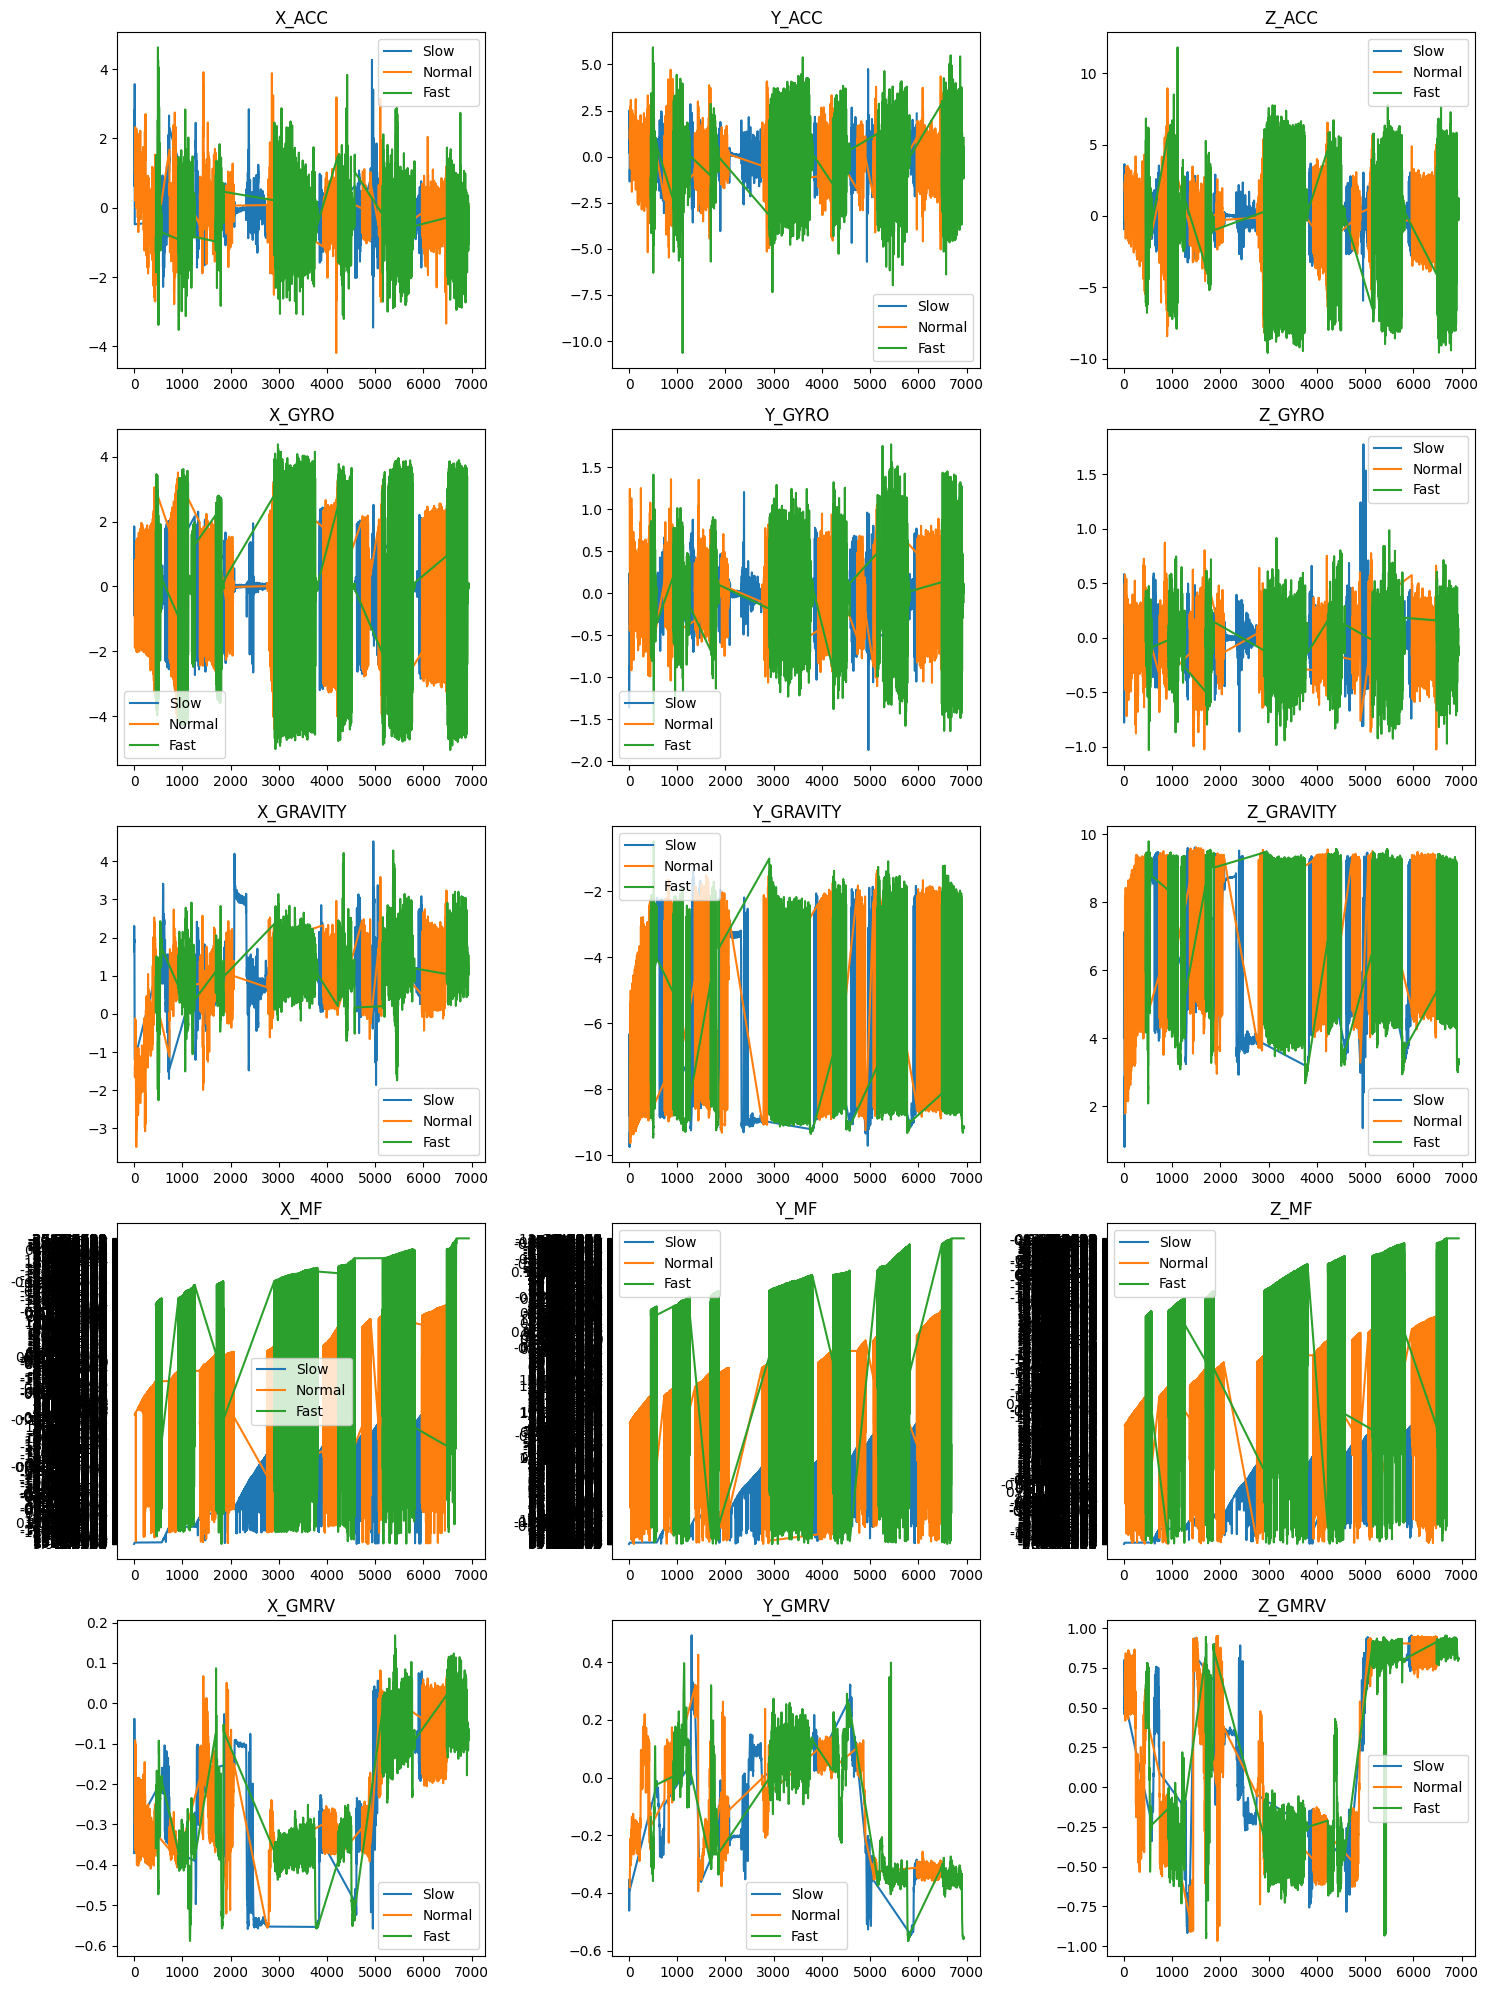

In [14]:
# Plot each feature for 'Slow', 'Normal, 'Fast' for 1 dataset
PlotFeatureStats('data/train/SENSOR_DATA0517.csv')

In [11]:
model.load_weights('weights/modelT-Bin-T:30-F1:0.770-AUC:0.720/modelT-Bin-T:30-F1:0.770-AUC:0.720.h5')

In [11]:
# Fitting the modell to all the csv files
r = PreprocessFilesAndTrain(glob('data/train/balanced/*.csv'), glob('data/test/balanced/*.csv'), model=model)

data/test/balanced/SENSOR_DATA0517.csv
OLD LENGTH: 6942
NEW LENGTH: 1005
data/train/balanced/FalseALL0421 (1).csv
OLD LENGTH: 3232
NEW LENGTH: 468
{0: 0.6083333333333333, 1: 2.8076923076923075}
Epoch 1/1000
146/146 [==============================] - 15s 49ms/step - loss: 0.8895 - accuracy: 0.1963 - val_loss: 0.6690 - val_accuracy: 0.5549
Epoch 2/1000
146/146 [==============================] - 6s 44ms/step - loss: 0.8653 - accuracy: 0.2032 - val_loss: 0.6701 - val_accuracy: 0.5538
Epoch 3/1000
146/146 [==============================] - 6s 45ms/step - loss: 0.8099 - accuracy: 0.2146 - val_loss: 0.6711 - val_accuracy: 0.5528
Epoch 4/1000
146/146 [==============================] - 6s 44ms/step - loss: 0.8150 - accuracy: 0.2123 - val_loss: 0.6722 - val_accuracy: 0.5579
Epoch 5/1000
146/146 [==============================] - 6s 44ms/step - loss: 0.7964 - accuracy: 0.2306 - val_loss: 0.6726 - val_accuracy: 0.5590
Epoch 6/1000
146/146 [==============================] - 6s 44ms/step - loss: 0.7

In [12]:
# Saving weights
filename = 'modelT-Bin-T:30-F1:0.770-AUC:0.720'

model.save_weights(f'./weights/{filename}/{filename}')

# Saving model
# saved_model = tf.saved_model.save(model, f'/tmp/model')
model.save(f"./weights/{filename}/{filename}.h5", save_format="h5")

INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets


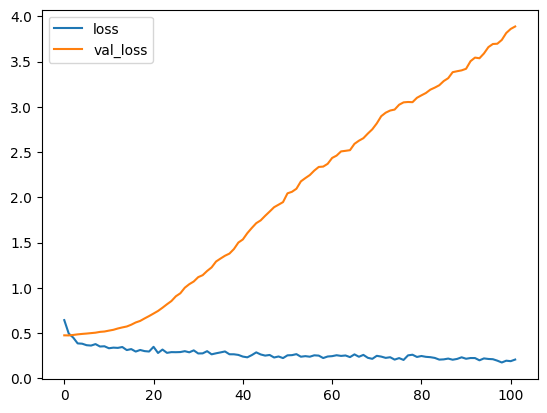

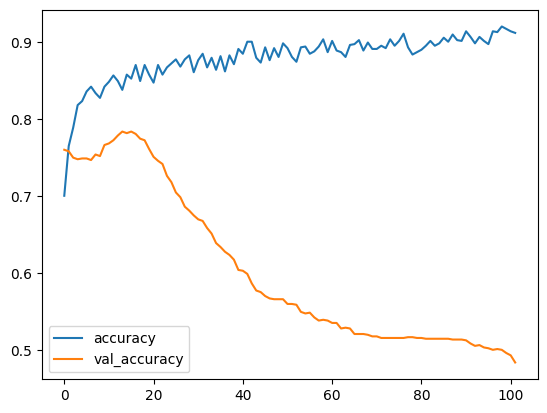

In [12]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Usual accuracy plotting
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [13]:
# Converting model to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(f'/tmp/model')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open(f'transformer.tflite', 'wb') as f:
  f.write(tflite_model)


In [13]:
# X_test, Y_test = SetupTest('data/test/balanced/SENSOR_DATA0517.csv')
X_test, Y_test = SetupTest('data/test/SENSOR_DATA1016.csv')
# X_test, Y_test = SetupTest('data/test/SlowALL1028.csv')


# Predict
Y_pred = model.predict(X_test)

# Convert to class and score prediction
def ProbPredToClassesAndScores(Y_pred: np.array, threshold = 0.5):
  Y_pred_classes = list()
  Y_pred_scores = list()
  for row in Y_pred:
      if row[0] >= threshold:
        Y_pred_classes.append(0)
        Y_pred_scores.append(row[0])
      else:
        Y_pred_classes.append(1)
        Y_pred_scores.append(row[1])

  return np.array(Y_pred_classes), np.array(Y_pred_scores)

Y_pred_classes, Y_pred_scores = ProbPredToClassesAndScores(Y_pred)
print(np.unique(Y_pred_classes))

data/test/SENSOR_DATA1016.csv
OLD LENGTH: 4346
NEW LENGTH: 629
19/19 [==============================] - 2s 64ms/step
[0 1]


In [14]:
# Calculate AUC
roc_auc_score(Y_test, Y_pred_classes)

0.7192654468310793

In [15]:
# F1 score
f1_score(Y_test, Y_pred_classes, average='weighted')

0.7691627528134193

In [16]:
# Help for imbalanced datasets https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def PlotConfusionMatrix():
    # Plotting confusion matrix
    cf_matrix = sklearn.metrics.confusion_matrix(Y_test, Y_pred_classes, normalize='all')
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    # Adding title names
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Adding label names to each category
    ax.xaxis.set_ticklabels(["Slow + Normal", "Fast"])
    ax.yaxis.set_ticklabels(["Slow + Normal", "Fast"])

    plt.show()

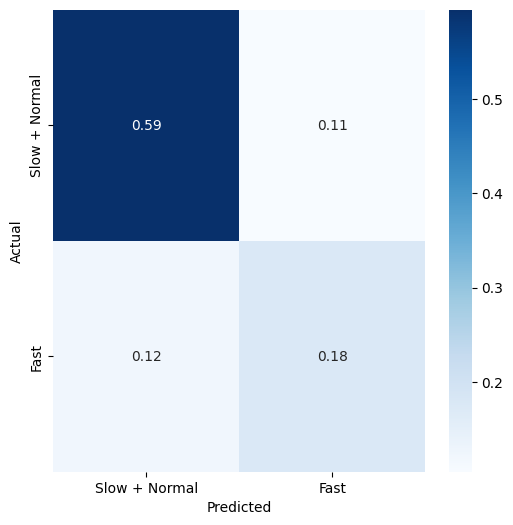

In [17]:
# Plot confusion matrix with the DEFAULT threshold value
PlotConfusionMatrix()

In [18]:
def get_best_threshold(tpr, fpr, thresholds):
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    return thresholds[ix]

# Defining the ROC (TP vs FP curve)
def PlotROC():
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc	
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_scores)
    auc_score = roc_auc_score(Y_test, Y_pred_classes)

    # Get best threshold's location
    best_threshold = get_best_threshold(tpr, fpr, thresholds)
    ix = np.argmin(np.abs(thresholds - best_threshold))
    best_tpr, best_fpr = tpr[ix], fpr[ix]

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_score))
    plt.scatter(best_fpr, best_tpr, marker='o', color='red', label='Best threshold')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    return fpr, tpr, thresholds

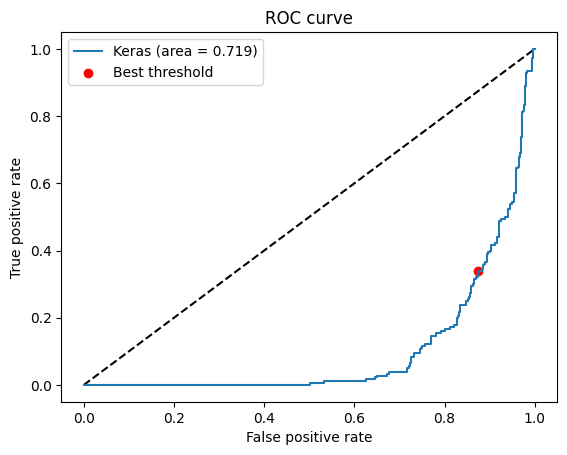

In [19]:
# Plotting ROC Curve
fpr, tpr, thresholds = PlotROC()

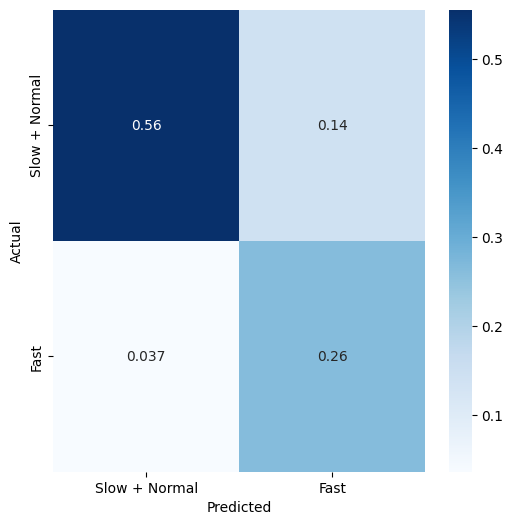

In [20]:
# Plot confusion matrix with the best threshold
best_threshold = get_best_threshold(tpr, fpr, thresholds)
Y_pred_classes, Y_pred_scores = ProbPredToClassesAndScores(Y_pred, threshold=best_threshold)

PlotConfusionMatrix()